In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter

import math

import json

# General Tool Functions

In [2]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_curvature_integral(best_scattering_data):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I
    smoothed_I_double_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=2, delta=np.mean(np.diff(Q_best)))
    I_double_prime_squared = smoothed_I_double_prime**2
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    return integral_val

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

# Your new functions (with dQ^2 scaling)
def calculate_slope_integral(best_scattering_data):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = 3
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)


## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

['../data/hanaro_Apr1/APR01031.ABS', '../data/hanaro_Apr1/APR01032.ABS', '../data/hanaro_Apr1/APR01033.ABS', '../data/hanaro_Apr1/APR01034.ABS', '../data/hanaro_Apr1/APR01035.ABS', '../data/hanaro_Apr1/APR01036.ABS', '../data/hanaro_Apr1/APR01037.ABS', '../data/hanaro_Apr1/APR01038.ABS']
173
173
173
173
173
173
173
173
count per sec: 16.67031758106049
average bin size: 0.00021469364161849711


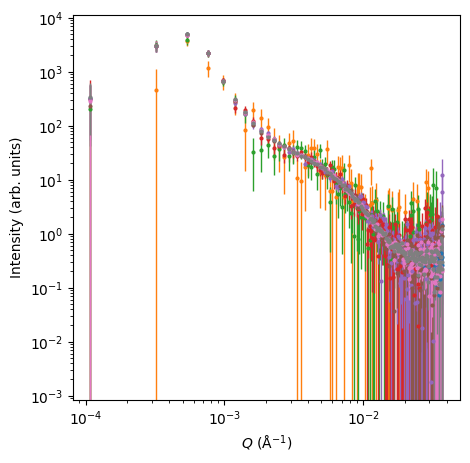

In [3]:
file_path = '../data/hanaro_Apr1/'
filenames = [f"APR{str(i).zfill(5)}.ABS" for i in range(1031, 1039)]
files = [os.path.join(file_path, fname) for fname in filenames]
print(files)

data_list = []
time_list = []
# Read data from files
for file in files:
    data = np.loadtxt(file, skiprows=14)
    # Extract collection time from filename using regex
    # Example filename: Apr01031.0058321.txt -> collection time is the number after the dot
    # Extract collection time from file by reading the header
    collection_time = None
    with open(file, 'r') as f:
        for _ in range(14):  # Read header lines
            line = f.readline()
            match = re.search(r'LABEL:.*?(\d+)s', line)
            if match:
                collection_time = int(match.group(1))
                break
    data_list.append(data)
    time_list.append(collection_time)
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
# ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))
print('average bin size: {}'.format((np.max(Q) - np.min(Q)) / len(Q)))
delta_Q_ave = (np.max(Q) - np.min(Q)) / len(Q)

## Produce Rebinned Data and Evaluate Performance

Using best dataset: Bin size = EQSANS, Time = 10000
Best data total counts: 10000
Using nbins = 192 for EQSANS synthetic data generation


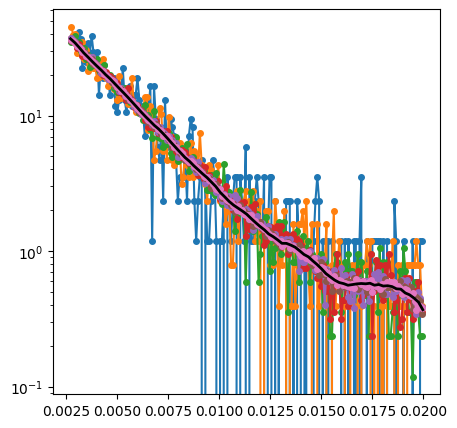

In [4]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
# L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Also filter ground truth for plotting
mask_gt = (best_data.Q < 0.02) & (best_data.Q > 0.0025)
best_I_interpolated = interpolate_best_I(best_data, best_data.Q, window_length=12)
# create best data_interpolated
best_data_interpolated = ScatteringData(best_data.Q[mask_gt], best_I_interpolated[mask_gt], best_data.I_err[mask_gt], best_data.dQ[mask_gt])

best_data = best_data_interpolated  # use interpolated best data as ground truth

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
L = Qmax - Qmin

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]
count_list = np.array(count_list, dtype=float)
count_list = count_list

# count_list = np.array(time_list)*np.mean(estimated_total_counts)/np.mean(time_list)

N_MC = 8
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = 192
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=5)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

ax.loglog(best_data.Q, best_data.I, label='Best Data (Ground Truth)', color='black', linestyle='-', linewidth=2)
ax.set_yscale('log')
ax.set_xscale('linear')

Time label: 1000.0, total counts: 1000.0, optimal DeltaQ_FD: 6.6358e-04 Å^-1, optimal bin number: 26
Theoretical optimal errors: FD = 1.5499e+00, GPR = 4.8889e-01, chi = 9.7405e-01
Time label: 3000.0, total counts: 3000.0, optimal DeltaQ_FD: 4.6010e-04 Å^-1, optimal bin number: 37
Theoretical optimal errors: FD = 7.4510e-01, GPR = 2.0301e-01, chi = 4.6827e-01
Time label: 10000.0, total counts: 10000.0, optimal DeltaQ_FD: 3.0800e-04 Å^-1, optimal bin number: 56
Theoretical optimal errors: FD = 3.3391e-01, GPR = 7.7484e-02, chi = 2.0985e-01
Time label: 30000.0, total counts: 30000.0, optimal DeltaQ_FD: 2.1356e-04 Å^-1, optimal bin number: 80
Theoretical optimal errors: FD = 1.6053e-01, GPR = 3.2175e-02, chi = 1.0089e-01
Time label: 100000.0, total counts: 100000.0, optimal DeltaQ_FD: 1.4296e-04 Å^-1, optimal bin number: 120
Theoretical optimal errors: FD = 7.1938e-02, GPR = 1.2280e-02, chi = 4.5211e-02
Time label: 300000.0, total counts: 300000.0, optimal DeltaQ_FD: 9.9125e-05 Å^-1, opti

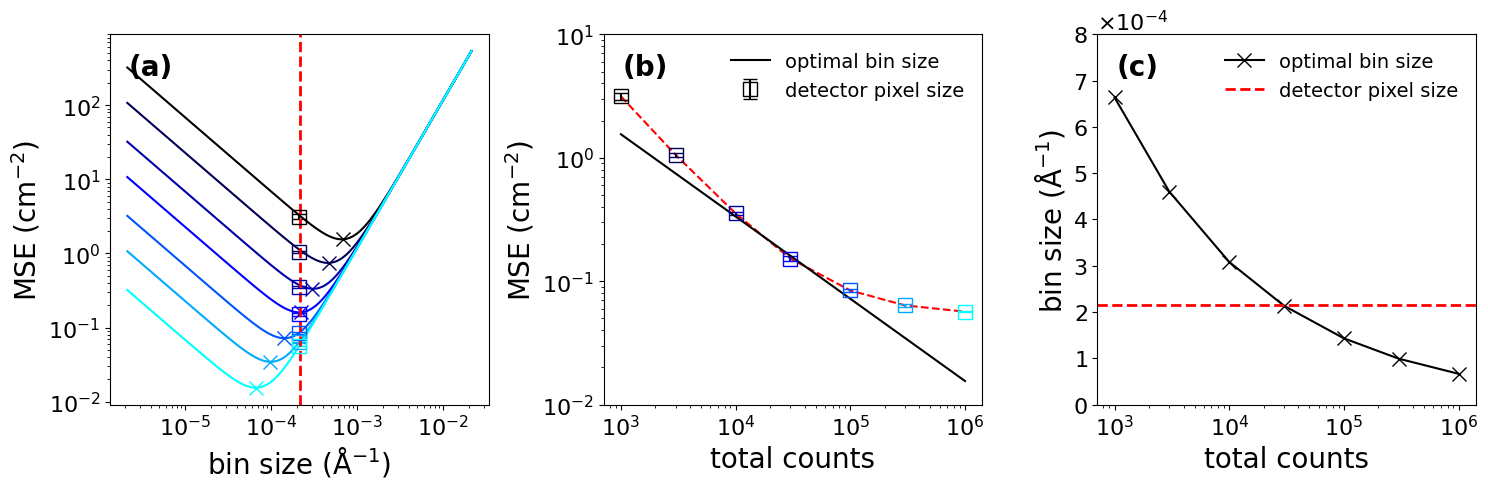

In [9]:
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# ax1: error as function of bin size
# ax2: error as function of total counts
# ax3: optimal bin size as function of total counts

# --- Precompute parameters for error laws ---
L = Qmax - Qmin
mean_I = np.mean(best_data.I)
integral_of_I_prime_sq = calculate_slope_integral(best_data)
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data)
beta = integral_of_I_prime_sq / (12 * L)
gamma = integral_of_I_double_prime_sq / (4 * L)
A0 = L * (mean_I ** 2)  # L * (interval-mean intensity)^2

fd_theoretical_mse_list = []
gpr_theoretical_mse_list = []
fd_theoretical_mse_ref1_list = []
fd_actual_mse_list = []
total_counts_list = []
optimal_bin_sizes = []

delta_Q = L/len(best_data.I)  # reference bin width for FD
bin_size_list = np.logspace(-2, 2, 9)*delta_Q
bin_size_list_fine = np.logspace(-2, 2, 100)*delta_Q

plot_gp_actual = []
plot_fd_actual = []
plot_parameters = [L, A0, beta, gamma]
for i_time, time_str in enumerate(count_list):
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    # --- Total counts for this time ---
    time_val = float(time_str)
    total_counts = time_val
    total_counts_list.append(total_counts)
    
    # Use a colormap to color lines by time
    custom_cmap = LinearSegmentedColormap.from_list("black_blue_cyan", ["black", "blue", "cyan"])
    color = custom_cmap(i_time / (len(count_list) - 1))

    # --- Theoretical optimal bin width and errors ---
    DeltaQ_FD_opt = ((A0 / total_counts) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
    optimal_bin_number = int(L / DeltaQ_FD_opt)
    optimal_bin_sizes.append(DeltaQ_FD_opt)
    print(f"Time label: {time_str}, total counts: {total_counts}, optimal DeltaQ_FD: {DeltaQ_FD_opt:.4e} Å^-1, optimal bin number: {optimal_bin_number}")

    alpha = A0 / total_counts
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0)+2.0 ** (-2.0 / 3.0))
    fd_theoretical_mse = ((A0 / total_counts) ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
    print(f"Theoretical optimal errors: FD = {fd_theoretical_mse:.4e}, GPR = {gpr_theoretical_mse:.4e}, chi = {chi:.4e}")
    fd_theoretical_mse_list.append(fd_theoretical_mse)
    gpr_theoretical_mse_list.append(gpr_theoretical_mse)
    
    fd_mse_list = []
    for i_bin, bin_size in enumerate(bin_size_list):
        fd_mse = alpha/bin_size + beta * (bin_size ** 2)
        fd_mse_list.append(fd_mse)

    fd_count_mse_fine_list = alpha/bin_size_list_fine
    fd_bin_mse_fine_list = beta * (bin_size_list_fine ** 2)
    fd_mse_fine_list = fd_count_mse_fine_list + fd_bin_mse_fine_list
    
    ax1.loglog(bin_size_list_fine, fd_mse_fine_list, '-', color=color, markersize=10, fillstyle='none')
    index_opt = np.argmin(np.abs(fd_mse_fine_list))
    label = None
    # if i_time == 0:
    #     label = 'optimal bin size'
    ax1.loglog(bin_size_list_fine[index_opt], fd_mse_fine_list[index_opt], 'x', color=color, label=label, markersize=10, fillstyle='none')

    # Evaluate alpha, beta, gamma, A0 for each MC sample at this total_counts
    alpha_list = []
    beta_list = []
    gamma_list = []
    A0_list = []
    fd_mse_mc_list = []

    for i_MC in range(N_MC):
        sd_syn = synthetic_data_list[i_MC][bin_size_key][collimation][time_str]
        Q = sd_syn.Q
        I = sd_syn.I
        L_mc, mean_I_mc, beta_mc, gamma_mc, A0_mc = _integrals_from_Qy(Q, I, sg=dict(window_frac=0.15, polyorder=3))
        alpha_mc = A0_mc / total_counts
        alpha_list.append(alpha_mc)
        beta_list.append(beta_mc)
        gamma_list.append(gamma_mc)
        A0_list.append(A0_mc)
        fd_mse_mc_list.append([alpha_mc / b + beta_mc * b**2 for b in bin_size_list])

    alpha_arr = np.array(alpha_list)
    beta_arr = np.array(beta_list)
    gamma_arr = np.array(gamma_list)
    A0_arr = np.array(A0_list)
    fd_mse_mc_arr = np.array(fd_mse_mc_list)

    fd_theoretical_mse_mc = ((A0_arr / total_counts) ** (2.0 / 3.0)) * (beta_arr ** (1.0 / 3.0)) * C_FD
    fd_theoretical_mse_mc_mean = np.mean(fd_theoretical_mse_mc)
    fd_theoretical_mse_mc_std = np.std(fd_theoretical_mse_mc)

    fd_mse_mc_mean = np.mean(fd_mse_mc_arr, axis=0)
    fd_mse_mc_std = np.std(fd_mse_mc_arr, axis=0)

    label = 'detector pixel size'
    ax2.errorbar(total_counts, fd_mse_mc_mean[4], yerr=fd_mse_mc_std[4], fmt='s', color=color, markersize=10, fillstyle='none', capsize=5, label=label if i_time == 0 else None)
    
    label = None
    # if i_time == 0:
    #     label = 'avg. detector bin size'
    ax1.errorbar(bin_size_list[4], fd_mse_mc_mean[4], yerr=fd_mse_mc_std[4], fmt='s', color=color, label=label, markersize=10, fillstyle='none', capsize=5)
    
    fd_actual_mse_list.append(fd_mse_mc_mean[4])
    
ax2.loglog(total_counts_list, fd_theoretical_mse_list, '-', color='k', label='optimal bin size', markersize=10)
ax2.loglog(total_counts_list, fd_actual_mse_list, '--', color='r', markersize=10, zorder = -10)
ax1.axvline(delta_Q_ave, color='red', linestyle='--', linewidth=2, label='detector bin size')
ax1.set_ylabel('MSE (cm$^{-2}$)', fontsize=20)
ax1.set_xlabel('bin size (Å$^{-1}$)', fontsize=20)
# ax1.legend(fontsize=14, frameon=False)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.set_xlabel('total counts', fontsize=20)
ax2.set_ylabel('MSE (cm$^{-2}$)', fontsize=20)
ax2.set_ylim(1e-2, 1e1)
ax2.legend(fontsize=14, frameon=False)
ax2.tick_params(axis='both', which='major', labelsize=16)

# Panel 3: Plot optimal bin size vs total counts
import matplotlib.ticker as mticker

ax3.loglog(total_counts_list, optimal_bin_sizes, 'x-', color='k', label='optimal bin size', markersize=10)
ax3.axhline(delta_Q_ave, color='red', linestyle='--', linewidth=2, label='detector pixel size')
ax3.set_xlabel('total counts', fontsize=20)
ax3.set_ylabel('bin size (Å$^{-1}$)', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.set_yscale('linear')
ax3.set_ylim(0, 0.0008)
ax3.legend(fontsize=14, frameon=False)

# Set scientific notation for y-axis with exponent on top
ax3.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.yaxis.get_offset_text().set_fontsize(16)
ax3.yaxis.get_offset_text().set_y(1.02)

# Add panel labels (a), (b), (c)
panel_labels = ['(a)', '(b)', '(c)']
for ax, label in zip(axs, panel_labels):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()


Optimal bin size at total counts=3000.0: 4.6010e-04 Å^-1


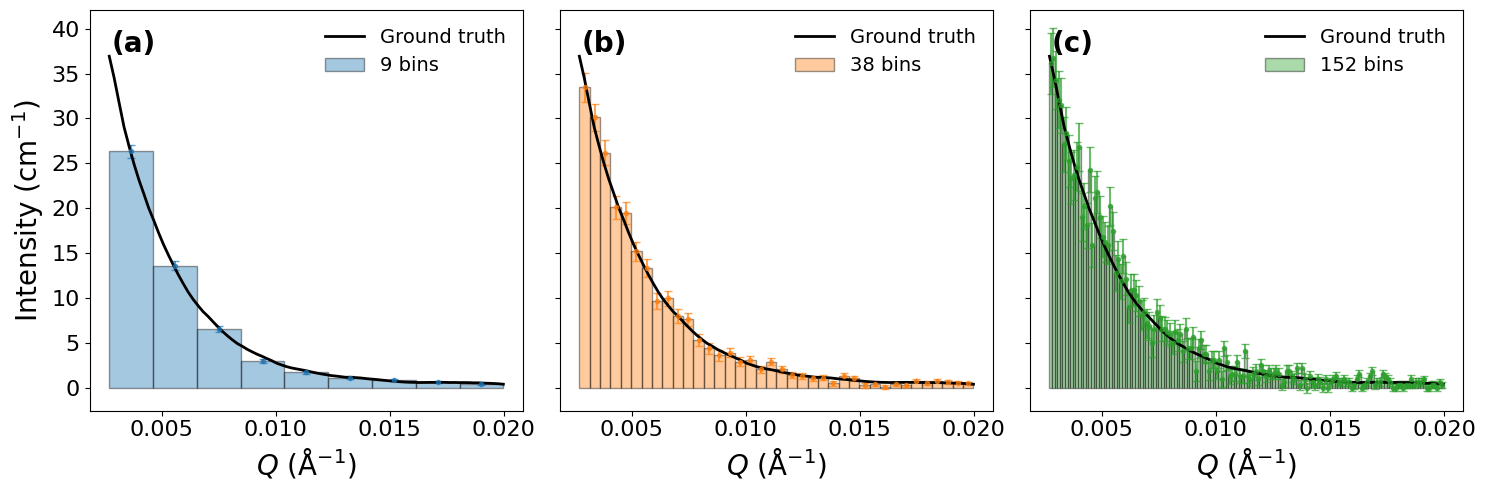

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# 1st time in count_list (index 0)
time_idx = 1
time_val = count_list[time_idx]

# Three different bin sizes: small, medium, large
# Calculate the theoretical optimal bin size for this total count
mean_I = np.mean(best_data.I)
A0 = L * (mean_I ** 2)
integral_of_I_prime_sq = calculate_slope_integral(best_data)
beta = integral_of_I_prime_sq / (12 * L)
DeltaQ_FD_opt = ((A0 / time_val) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
print(f"Optimal bin size at total counts={time_val}: {DeltaQ_FD_opt:.4e} Å^-1")
# Choose number of bins as integer values around the optimal bin size
optimal_nbins = int(np.round(L / DeltaQ_FD_opt))
nbins_list = [optimal_nbins // 4, optimal_nbins, optimal_nbins * 4]
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = [f'{n} bins' for n in nbins_list]

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
L = Qmax - Qmin

for ax, nbins, color, label in zip(axs, nbins_list, colors, labels):
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    # Compute mean intensity in each bin using the ground truth
    I_mean_uniform = np.empty(nbins, dtype=float)
    for i, Qc in enumerate(Q_centers):
        QL = Qc - 0.5 * bin_width
        QR = Qc + 0.5 * bin_width
        qgrid = np.linspace(QL, QR, samples_per_bin)
        I_vals = interpolate_best_I(best_data, qgrid, window_length=5)
        I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width

    I_sum = np.sum(I_mean_uniform)
    if I_sum > 0:
        counts_uniform = time_val * (I_mean_uniform / I_sum)
    else:
        counts_uniform = np.full(nbins, time_val / nbins)

    I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
    rng = np.random.default_rng()
    counts_sampled = rng.poisson(lam=counts_uniform)
    I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

    # Plot as bars
    ax.bar(Q_centers, I_uniform, width=bin_width, color=color, alpha=0.4, align='center', label=label, edgecolor='k')
    ax.errorbar(Q_centers, I_uniform, yerr=I_err_uniform, fmt='o', color=color, markersize=3, alpha=0.7, capsize=3)
    ax.plot(best_data.Q, best_data.I, color='black', lw=2, label='Ground truth')
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
    # ax.set_xlim(5e-3, 1e-2)
    if ax is axs[0]:
        ax.set_ylabel('Intensity (cm$^{-1}$)', fontsize=20)
    ax.legend(fontsize=14, frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
# Add panel labels (a), (b), (c)
panel_labels = ['(a)', '(b)', '(c)']
for ax, label in zip(axs, panel_labels):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()